# Module 3: Push Notifications DS

## Import libraries

In [52]:
import os
import boto3
import logging
import numpy as np
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, f1_score, confusion_matrix

logging.basicConfig(
    level=logging.INFO,  # Info level for general information
    format="%(asctime)s - %(levelname)s - %(message)s",
)

## Load dataset

In [53]:
load_dotenv()
AWW_API_KEY = os.getenv("AWW_API_KEY")
AWW_SECRET = os.getenv("AWW_SECRET")

s3 = boto3.client(
    's3',
    aws_access_key_id=AWW_API_KEY,
    aws_secret_access_key=AWW_SECRET
)
bucket_name = 'zrive-ds-data'
prefix = "groceries/box_builder_dataset/"

PROJECT_ROOT = Path().resolve().parent.parent
DATA_DIR = PROJECT_ROOT / "data"
DATA_DIR.mkdir(exist_ok=True)

logging.info(f"Data folder: {DATA_DIR}")

response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

for obj in response.get("Contents", []):
    file_key = obj["Key"]
    if file_key.endswith("/"):  # skip folder placeholders
        continue

    # Strip the first folder ('groceries/') and keep the inner folders
    relative_path = Path(*file_key.split("/")[1:])
    local_path = DATA_DIR / relative_path
    local_path.parent.mkdir(parents=True, exist_ok=True)

    if local_path.exists():
        logging.info(f"Already exists: {local_path}, skipping download.")
    else:
        s3.download_file(bucket_name, file_key, str(local_path))
        logging.info(f"Downloaded {local_path}")

2025-10-27 09:40:44,560 - INFO - Data folder: /Users/maria/Desktop/Zrive DS/zrive-ds/data


2025-10-27 09:40:45,091 - INFO - Already exists: /Users/maria/Desktop/Zrive DS/zrive-ds/data/box_builder_dataset/feature_frame.csv, skipping download.


In [54]:
df = pd.read_csv(DATA_DIR / "box_builder_dataset" / "feature_frame.csv")
df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


## Milestone 1: exploration phase

### Filter to at least 5 items bought

In [55]:
orders_with_5plus = (
    df[df["outcome"] == 1]              # only buy orders
      .groupby("order_id")["variant_id"]
      .nunique()                        # count unique variant_id por order_id
      .loc[lambda x: x >= 5]            # take >= 5 items
      .index                            # get the order_id index
)

df_filtered = df[df["order_id"].isin(orders_with_5plus)]


In [56]:
logging.info(f"Original dataset size: {df.shape[0]} rows")
logging.info(f"Filtered dataset size: {df_filtered.shape[0]} rows")
df_filtered.head()

2025-10-27 09:40:56,602 - INFO - Original dataset size: 2880549 rows
2025-10-27 09:40:56,604 - INFO - Filtered dataset size: 2163953 rows


,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


### Prepare the data

Now, we split the data intro train (70%), validation (20%) and test (10%). We have to take into account that our data has a temporal feature, so we split them in time.

/var/folders/45/_kywt6y9647bq9fvcw_fkvrw0000gn/T/ipykernel_48818/2142189591.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['order_date'] = pd.to_datetime(df_filtered['order_date'])


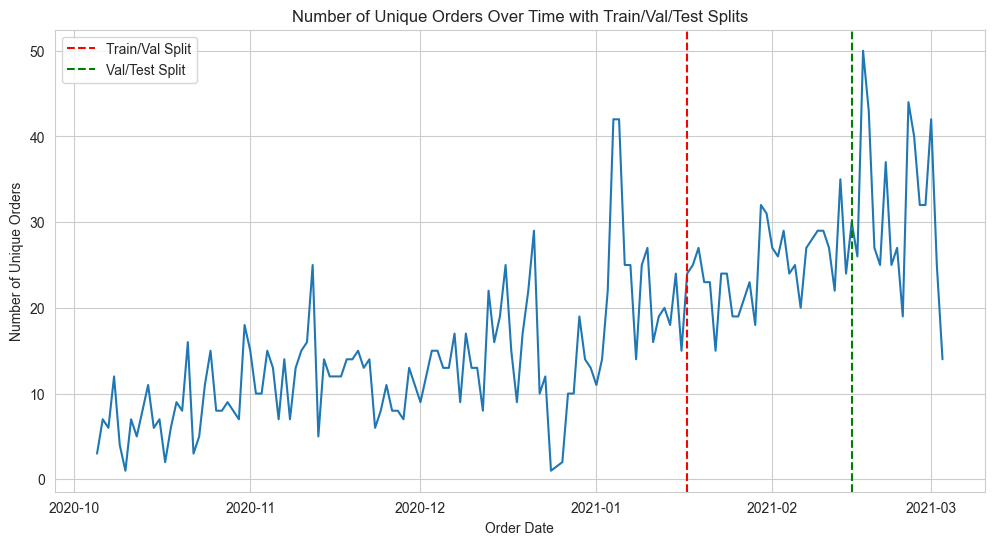

In [57]:
df_filtered['order_date'] = pd.to_datetime(df_filtered['order_date'])
orders_per_date = df_filtered.groupby('order_date')['order_id'].nunique().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=orders_per_date, x='order_date', y='order_id')
train_size = int(0.7 * len(orders_per_date))
val_size = int(0.2 * len(orders_per_date))
train_end_date = orders_per_date['order_date'].iloc[train_size - 1]
val_end_date = orders_per_date['order_date'].iloc[train_size + val_size - 1]
plt.axvline(x=train_end_date, color='r', linestyle='--', label='Train/Val Split')
plt.axvline(x=val_end_date, color='g', linestyle='--', label='Val/Test Split')
plt.legend()
plt.title('Number of Unique Orders Over Time with Train/Val/Test Splits')
plt.xlabel('Order Date')
plt.ylabel('Number of Unique Orders')
plt.show()

In [58]:
def temporal_split_by_order(
    df, 
    date_col, 
    order_col="order_id", 
    feature_cols=None,
    target_col="outcome", 
    train_size=0.7, 
    val_size=0.2, 
    test_size=0.1
):
    """
    Splits a DataFrame into train, validation, and test sets based on order date,
    ensuring no items from the same order appear in multiple splits.
    """
    if not abs(train_size + val_size + test_size - 1.0) < 1e-6:
        raise ValueError("train_size + val_size + test_size must equal 1.0")

    # Order unique orders by date
    orders_sorted = (
        df[[order_col, date_col]]
        .drop_duplicates()
        .sort_values(date_col)
    )

    n_orders = len(orders_sorted)
    train_end = int(train_size * n_orders)
    val_end = int((train_size + val_size) * n_orders)

    # Assign orders to splits
    train_orders = orders_sorted.iloc[:train_end][order_col]
    val_orders = orders_sorted.iloc[train_end:val_end][order_col]
    test_orders = orders_sorted.iloc[val_end:][order_col]

    # Filter DataFrame based on order assignments
    train_df = df[df[order_col].isin(train_orders)]
    val_df = df[df[order_col].isin(val_orders)]
    test_df = df[df[order_col].isin(test_orders)]

    # If feature_cols is specified, select only those columns along with target_col
    if feature_cols is not None:
        train_df = train_df[feature_cols + [target_col]]
        val_df = val_df[feature_cols + [target_col]]
        test_df = test_df[feature_cols + [target_col]]

    # Divide into X and y
    X_train = train_df.drop(columns=[target_col])
    y_train = train_df[target_col]
    X_val = val_df.drop(columns=[target_col])
    y_val = val_df[target_col]
    X_test = test_df.drop(columns=[target_col])
    y_test = test_df[target_col]

    logging.info(f"Total unique orders: {n_orders}")
    logging.info(f"Train orders: {len(train_orders)} ({train_size*100:.1f}%)")
    logging.info(f"Val orders: {len(val_orders)} ({val_size*100:.1f}%)")
    logging.info(f"Test orders: {len(test_orders)} ({test_size*100:.1f}%)")
    logging.info(f"Train rows: {train_df.shape[0]}, Val rows: {val_df.shape[0]}, Test rows: {test_df.shape[0]}")

    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = temporal_split_by_order(
    df=df_filtered,
    date_col="order_date",
    order_col="order_id",
    feature_cols=["product_type", "ordered_before", "abandoned_before", "active_snoozed", "set_as_regular", "global_popularity"],
    target_col="outcome"
)
logging.info(f"Shapes -> Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

2025-10-27 09:40:58,226 - INFO - Total unique orders: 2603
2025-10-27 09:40:58,227 - INFO - Train orders: 1822 (70.0%)
2025-10-27 09:40:58,228 - INFO - Val orders: 520 (20.0%)
2025-10-27 09:40:58,229 - INFO - Test orders: 261 (10.0%)
2025-10-27 09:40:58,230 - INFO - Train rows: 1446691, Val rows: 466801, Test rows: 250461
2025-10-27 09:40:58,266 - INFO - Shapes -> Train: (1446691, 6), Val: (466801, 6), Test: (250461, 6)


The next step is transforming the categorical features into numericals to train the model. As we have so many categories in `product_type` one-hot encoding would increase the df size a lot, so we have to use a different encoding method. The final idea was to use frequency encoding because other, such as label encoding, create an inexisting order.

In [59]:
freq_map = X_train["product_type"].value_counts(normalize=True)
X_train["product_type"] = X_train["product_type"].map(freq_map)
X_val["product_type"] = X_val["product_type"].map(freq_map).fillna(0)
X_test["product_type"] = X_test["product_type"].map(freq_map).fillna(0)

logging.info("Applied frequency encoding to 'product_type'")

2025-10-27 09:40:58,629 - INFO - Applied frequency encoding to 'product_type'


Lastly, we scale the data, which is very important for models like Ridge and Lasso since they penalise high weights.

In [60]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### Baseline model

We can use a feature, such as `global popularity`, as a baseline model. That way, we can compare the metrics to understand if the model improves.

In [61]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

roc_auc = roc_auc_score(y_train, X_train_scaled_df['global_popularity'])
pr_auc = average_precision_score(y_train, X_train_scaled_df['global_popularity'])
logging.info(f"Global Popularity - ROC-AUC: {roc_auc:.4f}, PR-AUC: {pr_auc:.4f}")

2025-10-27 09:41:01,491 - INFO - Global Popularity - ROC-AUC: 0.7868, PR-AUC: 0.0600


### Linear models

#### OLS

We used `class_weight='balanced'` because our target variable is imbalanced. Without it, the model would mostly focus on the bigger class and might miss the smaller one. Balancing the weights makes the model pay more attention to the minority class, so it can spot rare events better and give a fairer performance overall.

In [62]:
model = LogisticRegression(C=1.0, penalty='l2', max_iter=1000, class_weight='balanced')
model.fit(X_train_scaled, y_train)

y_val_pred_ols = model.predict_proba(X_val_scaled)[:, 1]
val_f1 = f1_score(y_val, y_val_pred_ols.round())

logging.info(f"Validation F1 Score: {val_f1:.4f}")

2025-10-27 09:41:04,550 - INFO - Validation F1 Score: 0.1207


An interesting point is understanding the importance of each feature in the model results.

In [63]:
importance = pd.DataFrame({
    "feature": X_train.columns,
    "coef": model.coef_.ravel()
}).sort_values("coef", ascending=False)

print(importance)

             feature      coef
5  global_popularity  0.900260
1     ordered_before  0.387968
2   abandoned_before  0.159990
4     set_as_regular  0.091833
0       product_type  0.072544
3     active_snoozed  0.030826


#### Ridge

In [64]:
C_values = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

results = []
for C in C_values:
    model = LogisticRegression(C=C, penalty='l2', max_iter=1000, class_weight='balanced')
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict_proba(X_val_scaled)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    ap = average_precision_score(y_val, y_pred)
    results.append({"C": C, "auc": auc, "ap": ap})

results_df = pd.DataFrame(results).sort_values("ap", ascending=False).reset_index(drop=True)
logging.info(f"Logistic Regression tuning results (sorted by AP):\n{results_df}")

best_C = results_df.loc[0, "C"]
logging.info(f"Selected best C: {best_C}")

best_model_l2 = LogisticRegression(C=best_C, penalty='l2', max_iter=1000, class_weight='balanced')
best_model_l2.fit(X_train_scaled, y_train)

y_val_pred_l2 = best_model_l2.predict_proba(X_val_scaled)[:, 1]
val_f1 = f1_score(y_val, y_val_pred_l2.round())
logging.info(f"Validation F1 Score: {val_f1:.4f}")

2025-10-27 09:41:25,203 - INFO - Logistic Regression tuning results (sorted by AP):
         C       auc        ap
0    0.001  0.837265  0.145544
1    0.010  0.837298  0.145466
2    0.100  0.837299  0.145452
3    1.000  0.837299  0.145451
4  100.000  0.837299  0.145451
5   10.000  0.837299  0.145451
2025-10-27 09:41:25,204 - INFO - Selected best C: 0.001
2025-10-27 09:41:28,519 - INFO - Validation F1 Score: 0.1209


In [65]:
importance = pd.DataFrame({
    "feature": X_train.columns,
    "coef": best_model_l2.coef_.ravel()
}).sort_values("coef", ascending=False)

print(importance)

             feature      coef
5  global_popularity  0.895136
1     ordered_before  0.387280
2   abandoned_before  0.159366
4     set_as_regular  0.091619
0       product_type  0.072659
3     active_snoozed  0.030796


#### Lasso

In [66]:
C_values = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

results = []
for C in C_values:
    model = LogisticRegression(C=C, penalty='l1', solver='liblinear', max_iter=1000, class_weight='balanced')
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict_proba(X_val_scaled)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    ap = average_precision_score(y_val, y_pred)
    results.append({"C": C, "auc": auc, "ap": ap})

results_df = pd.DataFrame(results).sort_values("ap", ascending=False).reset_index(drop=True)
logging.info(f"Logistic Regression L1 tuning results:\n{results_df}")

best_C = results_df.loc[0, "C"]
logging.info(f"Selected best C for L1 Logistic Regression: {best_C}")

# Train final model
best_model_l1 = LogisticRegression(C=best_C, penalty='l1', solver='liblinear', max_iter=1000, class_weight='balanced')
best_model_l1.fit(X_train_scaled, y_train)

y_val_pred_l1 = best_model_l1.predict_proba(X_val_scaled)[:, 1]
val_f1 = f1_score(y_val, y_val_pred_l1.round())
logging.info(f"Validation F1 Score: {val_f1:.4f}")


2025-10-27 09:41:46,772 - INFO - Logistic Regression L1 tuning results:
         C       auc        ap
0   10.000  0.837303  0.145460
1  100.000  0.837303  0.145459
2    1.000  0.837303  0.145459
3    0.100  0.837303  0.145455
4    0.010  0.837312  0.145433
5    0.001  0.837467  0.145172
2025-10-27 09:41:46,774 - INFO - Selected best C for L1 Logistic Regression: 10.0
2025-10-27 09:41:49,843 - INFO - Validation F1 Score: 0.1207


In [67]:
importance = pd.DataFrame({
    "feature": X_train.columns,
    "coef": best_model_l1.coef_.ravel()
}).sort_values("coef", ascending=False)

print(importance)

             feature      coef
5  global_popularity  0.900266
1     ordered_before  0.387942
2   abandoned_before  0.160190
4     set_as_regular  0.091843
0       product_type  0.072530
3     active_snoozed  0.030741


#### Logistic Regression

In [68]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

results_log = []
for C in C_values:
    model = LogisticRegression(C=C, max_iter=1000, class_weight='balanced')
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict_proba(X_val_scaled)[:, 1]
    results_log.append({
        "C": C,
        "auc": roc_auc_score(y_val, y_pred),
        "ap": average_precision_score(y_val, y_pred)
    })

results_log_df = pd.DataFrame(results_log).sort_values("ap", ascending=False).reset_index(drop=True)
logging.info(f"Logistic tuning results (sorted by AP):\n{results_log_df}")

best_C = results_log_df.loc[0, "C"]
logging.info(f"Selected best C: {best_C}")

# retrain best logistic model and update variables
logreg = LogisticRegression(C=best_C, max_iter=1000, class_weight='balanced')
logreg.fit(X_train_scaled, y_train)

y_val_pred_log = logreg.predict_proba(X_val_scaled)[:, 1]

auc_log = roc_auc_score(y_val, y_val_pred_log)
ap_log = average_precision_score(y_val, y_val_pred_log)

logging.info(f"Logistic Regression F1 Score: {f1_score(y_val, y_val_pred_log.round()):.4f}")

2025-10-27 09:42:09,254 - INFO - Logistic tuning results (sorted by AP):
         C       auc        ap
0    0.001  0.837265  0.145544
1    0.010  0.837298  0.145466
2    0.100  0.837299  0.145452
3    1.000  0.837299  0.145451
4  100.000  0.837299  0.145451
5   10.000  0.837299  0.145451
2025-10-27 09:42:09,255 - INFO - Selected best C: 0.001
2025-10-27 09:42:13,408 - INFO - Logistic Regression F1 Score: 0.1209


In [69]:
importance = pd.DataFrame({
    "feature": X_train.columns,
    "coef": logreg.coef_.ravel()
}).sort_values("coef", ascending=False)

print(importance)

             feature      coef
5  global_popularity  0.895136
1     ordered_before  0.387280
2   abandoned_before  0.159366
4     set_as_regular  0.091619
0       product_type  0.072659
3     active_snoozed  0.030796


### Conclusions

Across the four linear models, the F1 scores remain generally low, reflecting the strong class imbalance in the dataset and the models’ tendency to predict the negative class. They all have a score around 0.12.

#### Confusion matrices

Now, we use the confusion matrix to understand the predictions made by each model. We mantain the threshold as 0'5 because it is the default cutoff in binary classification: values above 0.5 are treated as positives and below as negatives. This makes it easier to compare all models on the same basis.

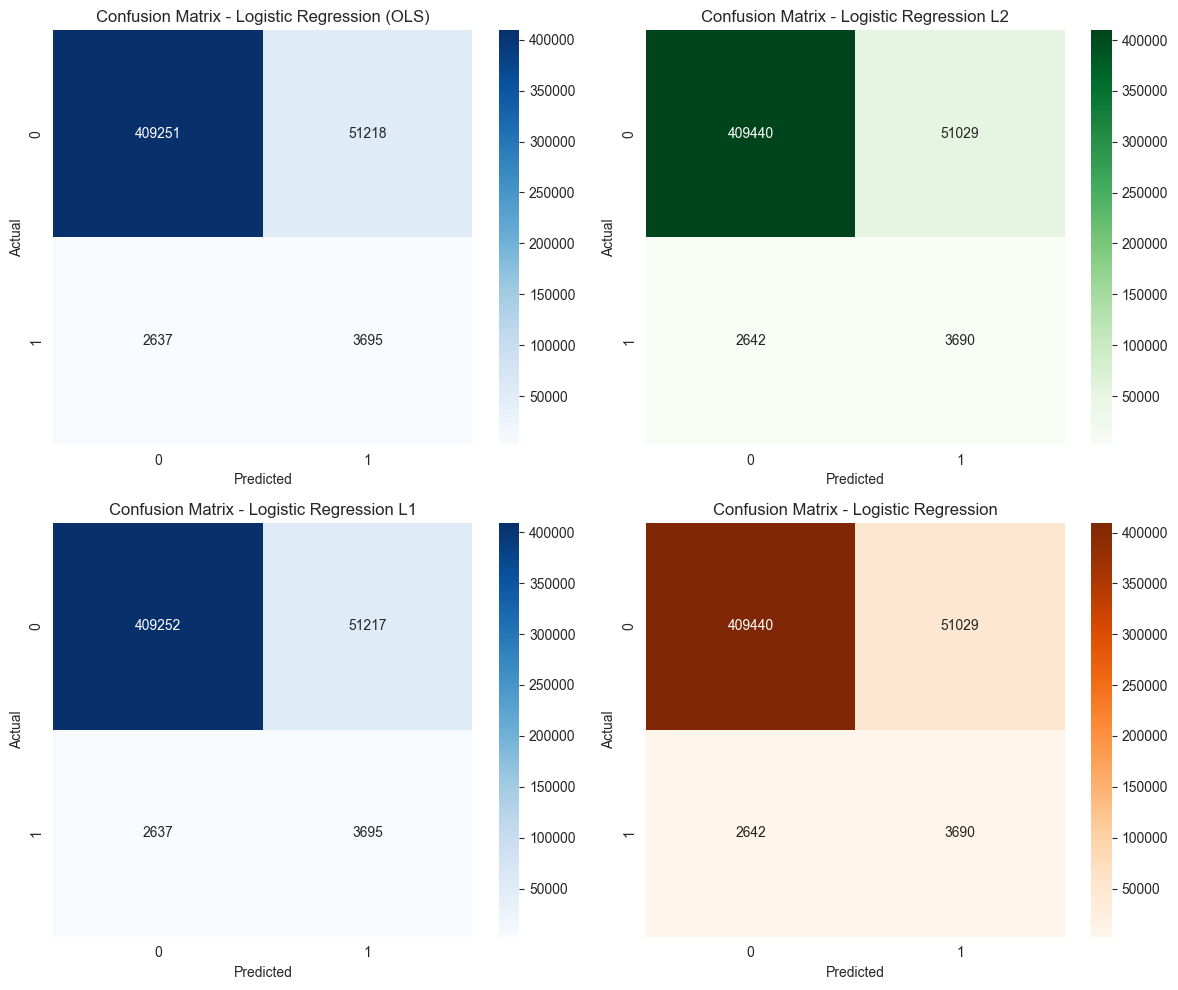

In [70]:
cm_ols = confusion_matrix(y_val, y_val_pred_ols.round())
cm_ridge = confusion_matrix(y_val, y_val_pred_l2.round())
cm_lasso = confusion_matrix(y_val, y_val_pred_l1.round())
cm_log = confusion_matrix(y_val, y_val_pred_log.round())

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.heatmap(cm_ols, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_xlabel('Predicted'); axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_title('Confusion Matrix - Logistic Regression (OLS)')

sns.heatmap(cm_ridge, annot=True, fmt='d', cmap='Greens', ax=axes[0, 1])
axes[0, 1].set_xlabel('Predicted'); axes[0, 1].set_ylabel('Actual')
axes[0, 1].set_title('Confusion Matrix - Logistic Regression L2')

sns.heatmap(cm_lasso, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_xlabel('Predicted'); axes[1, 0].set_ylabel('Actual')
axes[1, 0].set_title('Confusion Matrix - Logistic Regression L1')

sns.heatmap(cm_log, annot=True, fmt='d', cmap='Oranges', ax=axes[1, 1])
axes[1, 1].set_xlabel('Predicted'); axes[1, 1].set_ylabel('Actual')
axes[1, 1].set_title('Confusion Matrix - Logistic Regression')

fig.tight_layout()
plt.show()

Looking at the confusion matrices we can see how all the models perform quite similarly. They tend to predict more 0 than 1, due to the imbalanced classes.

#### Curves

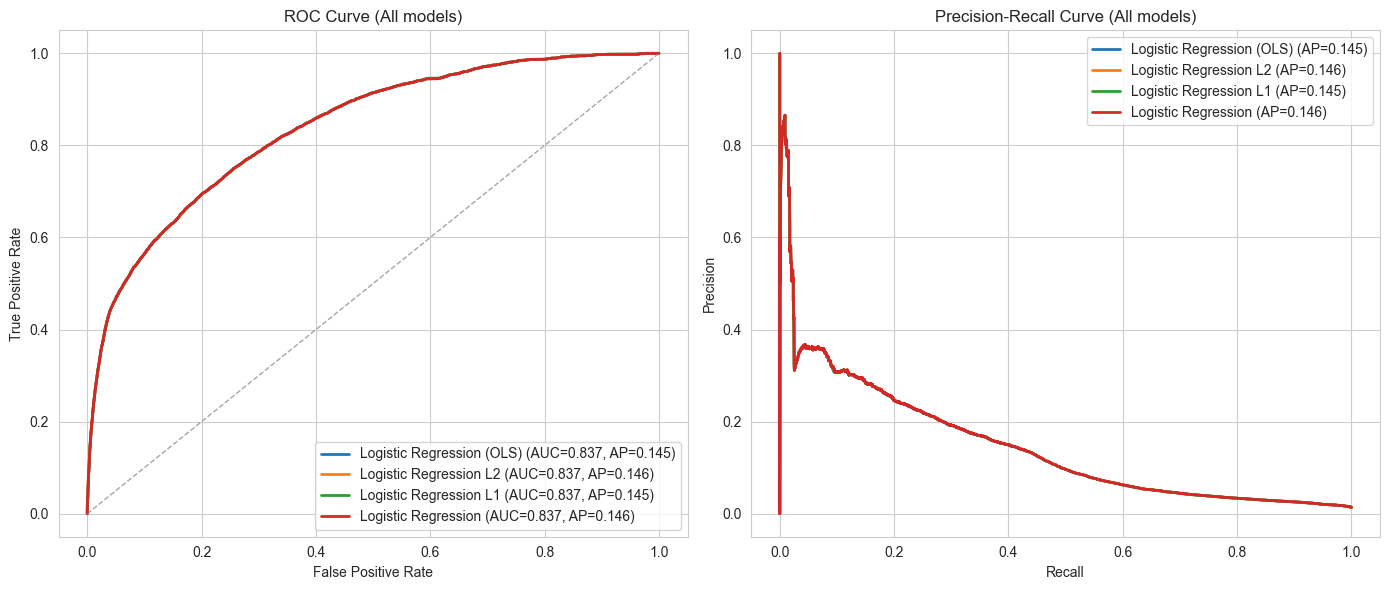

In [72]:
models = [
    ("Logistic Regression (OLS)", y_val_pred_ols),
    ("Logistic Regression L2", y_val_pred_l2),
    ("Logistic Regression L1", y_val_pred_l1),
    ("Logistic Regression", y_val_pred_log),
]

metrics = []
for name, y_pred in models:
    auc_ = roc_auc_score(y_val, y_pred)
    ap_ = average_precision_score(y_val, y_pred)
    metrics.append((name, y_pred, auc_, ap_))

sns.set_style("whitegrid")
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# ROC subplot
ax_roc = axs[0]
for name, y_pred, auc_, ap_ in metrics:
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    ax_roc.plot(fpr, tpr, lw=2, label=f"{name} (AUC={auc_:.3f}, AP={ap_:.3f})")
ax_roc.plot([0, 1], [0, 1], color="grey", lw=1, linestyle="--", alpha=0.7)
ax_roc.set_xlabel("False Positive Rate")
ax_roc.set_ylabel("True Positive Rate")
ax_roc.set_title("ROC Curve (All models)")
ax_roc.legend(loc="lower right")
ax_roc.grid(True)

# Precision-Recall subplot
ax_pr = axs[1]
for name, y_pred, auc_, ap_ in metrics:
    precision, recall, _ = precision_recall_curve(y_val, y_pred)
    ax_pr.plot(recall, precision, lw=2, label=f"{name} (AP={ap_:.3f})")
ax_pr.set_xlabel("Recall")
ax_pr.set_ylabel("Precision")
ax_pr.set_title("Precision-Recall Curve (All models)")
ax_pr.legend(loc="upper right")
ax_pr.grid(True)

fig.tight_layout()
plt.show()

In general, the AUC value is high, which means a good model performance, but the AP value is very low. Since the dataset is imbalanced, we have more `outcome=0` than `outcome = 1`, we get really low precision for True Positives.

#### Model selection

Since they all perform in the same way, it doesn't really matter which one to choose. However, Logistic Regression is simpler than the others, so it is going to be our choice.